# Question 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/ml-1b')
os.chdir('/content/drive/My Drive/Colab Notebooks/ml-1b')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ml-1b


In [2]:
from time import process_time
import random
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay


from cab420_a1b_q2_utils import *


Load the data

In [3]:
train_X, train_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Q2/')
print(train_X.shape)
print(train_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)
# plot_images(gallery_X, gallery_Y)


(5933, 128, 64, 3)
(5933,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


## Pre-Processing

In [4]:
# resize data and convert to grayscale for PCA
img_size = (64, 32)
train_X_small = convert_to_grayscale(resize(train_X, (64, 32)))
print(train_X_small.shape)
gallery_X_small = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X_small.shape)
probe_X_small = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X_small.shape)

(5933, 64, 32, 1)
(301, 64, 32, 1)
(301, 64, 32, 1)


In [5]:
train_time_results = {}
inference_time_results = {}

## Task 1
Develop and a non-deep learning method using one of the dimension reduction meth-
ods covered in Week 6 for person re-identification. The method should be evaluated on
the test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative
match characteristic) curve should also be provided.

In [6]:
print(probe_X_small.shape)
vectorise(probe_X_small).shape

(301, 64, 32, 1)


(301, 2048)

(301, 457)
(301, 457)
(301,)
0.04983388704318937
0.10963455149501661
0.15614617940199335


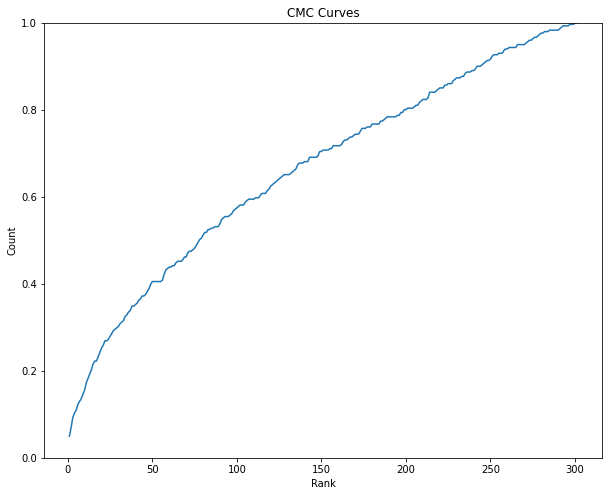

In [7]:
pca = decomposition.PCA()

# get a start time
time_1 = process_time()

pca.fit(vectorise(train_X_small))
# time2
time_2 = process_time()

transformed = pca.transform(vectorise(train_X_small))

time_3 = process_time()

# record runtime
train_time_results["PCA"] = time_2 - time_1
inference_time_results["PCA"] = time_3 - time_2

gallery_feat = pca.transform(vectorise( gallery_X_small))
probe_feat = pca.transform(vectorise( probe_X_small))

cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]
top90 = numpy.where(cumulative_sum > 0.90)[0][0]


transformed_train_95 = transformed[:, 0:top95]
gallery_feat_95 = gallery_feat[:, 0:top95]
probe_feat_95 = probe_feat[:, 0:top95]

print(gallery_feat_95.shape)
print(probe_feat_95.shape)
ranked_hist = get_ranked_histogram_l1_distance(gallery_feat_95, gallery_Y, probe_feat_95, probe_Y, False)
pca_cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(pca_cmc)

print(pca_cmc.shape)
pca_top_1 = pca_cmc[0]
pca_top_5 = pca_cmc[4]
pca_top_10 = pca_cmc[9]


print(pca_top_1)
print(pca_top_5)
print(pca_top_10)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


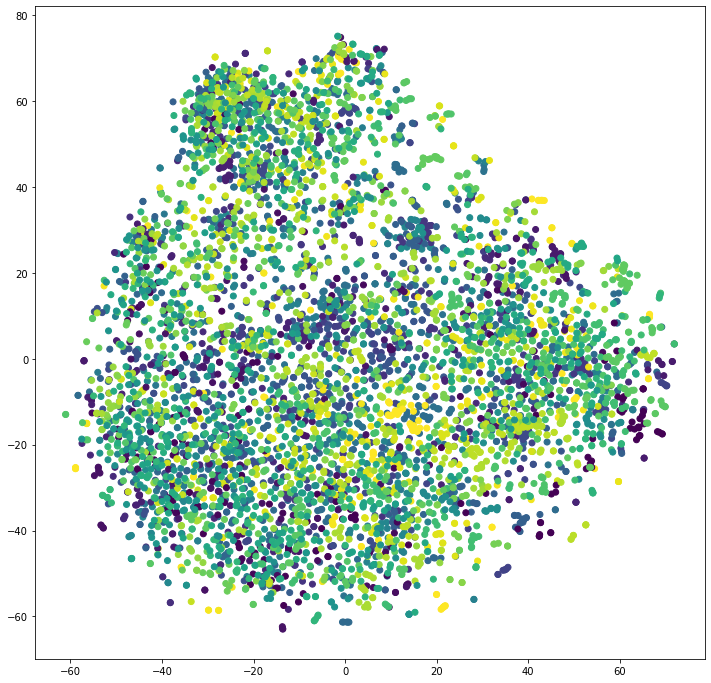

In [8]:
tsne_transformed = TSNE(random_state=4).fit_transform(transformed_train_95)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c = train_Y.flatten());

### Visualize Principal Components

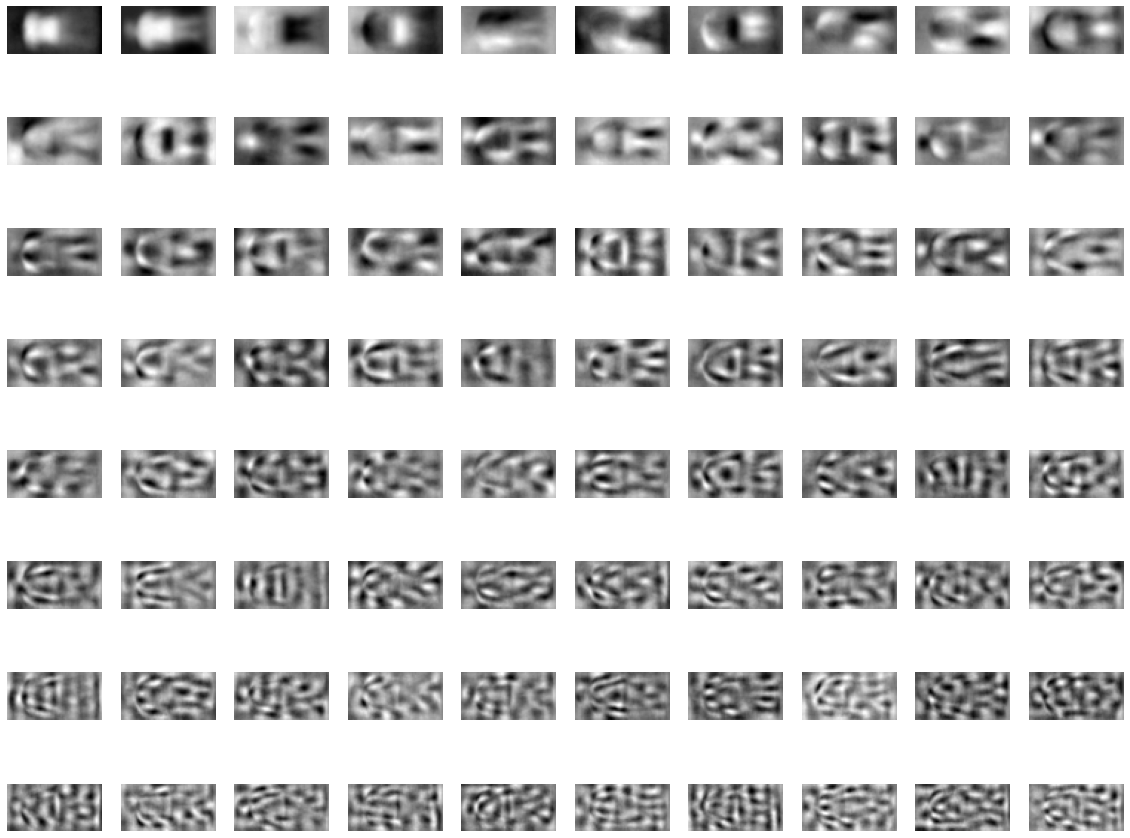

In [9]:
fig = plt.figure(figsize=[20, 16])
for i in range(80):
    ax = fig.add_subplot(8, 10, i + 1)
    pc = numpy.reshape(pca.components_[i,:], img_size)        
    ax.imshow(pc.transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

Text(0.5, 0, 'Number of Components')

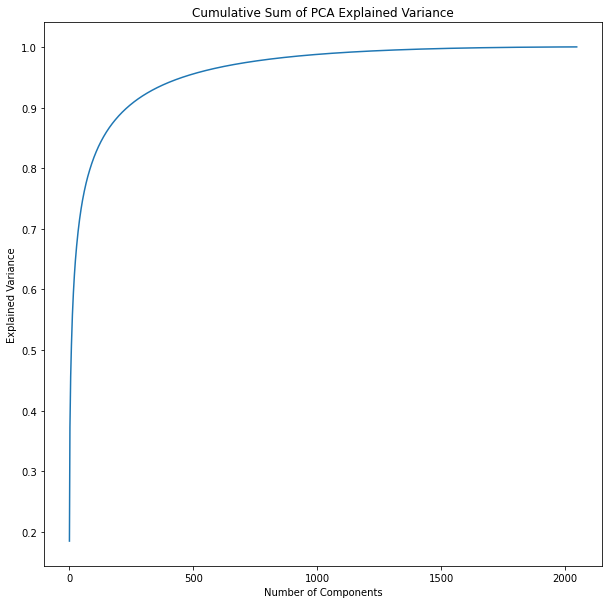

In [10]:
cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
ax.plot(cumulative_sum)
ax.set_title('Cumulative Sum of PCA Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Number of Components')

In [11]:
top90 = numpy.where(cumulative_sum > 0.90)[0][0]
print('90% in ' + '%d' % (top90+1) + ' components')
top95 = numpy.where(cumulative_sum > 0.95)[0][0]
print('95% in ' + '%d' % (top95+1) + ' components')
top99 = numpy.where(cumulative_sum > 0.99)[0][0]
print('99% in ' + '%d' % (top99+1) + ' components')

90% in 235 components
95% in 458 components
99% in 1079 components


### Reconstruct PCA

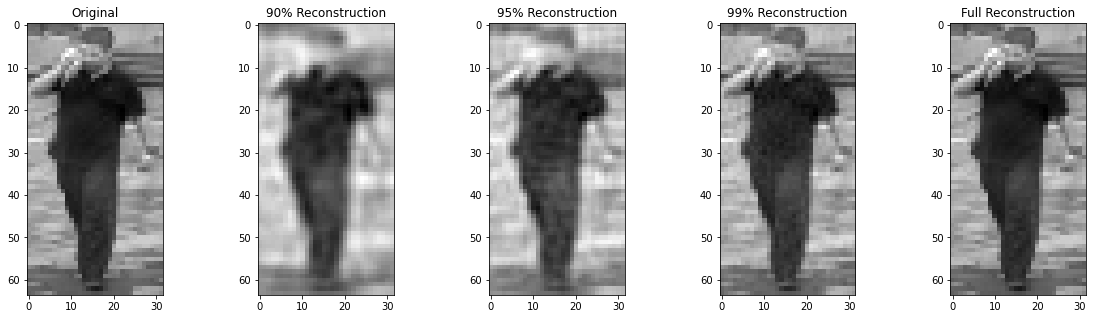

In [12]:
face_id = 3
train_fea = vectorise(train_X_small)
fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 5, 1)
ax.imshow(numpy.reshape(train_fea[face_id,:] - pca.mean_, img_size), cmap=plt.get_cmap('gray'))
ax.set_title('Original');

ax = fig.add_subplot(1, 5, 2)
ax.imshow(numpy.reshape(pca.components_[0:top90,:].transpose().dot(numpy.reshape(transformed[face_id,0:top90], (-1, 1))), img_size), cmap=plt.get_cmap('gray'))
ax.set_title('90% Reconstruction');

ax = fig.add_subplot(1, 5, 3)
ax.imshow(numpy.reshape(pca.components_[0:top95,:].transpose().dot(numpy.reshape(transformed[face_id,0:top95], (-1, 1))), img_size), cmap=plt.get_cmap('gray'))
ax.set_title('95% Reconstruction');

ax = fig.add_subplot(1, 5, 4)
ax.imshow(numpy.reshape(pca.components_[0:top99,:].transpose().dot(numpy.reshape(transformed[face_id,0:top99], (-1, 1))), img_size), cmap=plt.get_cmap('gray'))
ax.set_title('99% Reconstruction');

ax = fig.add_subplot(1, 5, 5)
ax.imshow(numpy.reshape(pca.components_[:,:].transpose().dot(numpy.reshape(transformed[face_id,:], (-1, 1))), img_size), cmap=plt.get_cmap('gray'))
ax.set_title('Full Reconstruction');

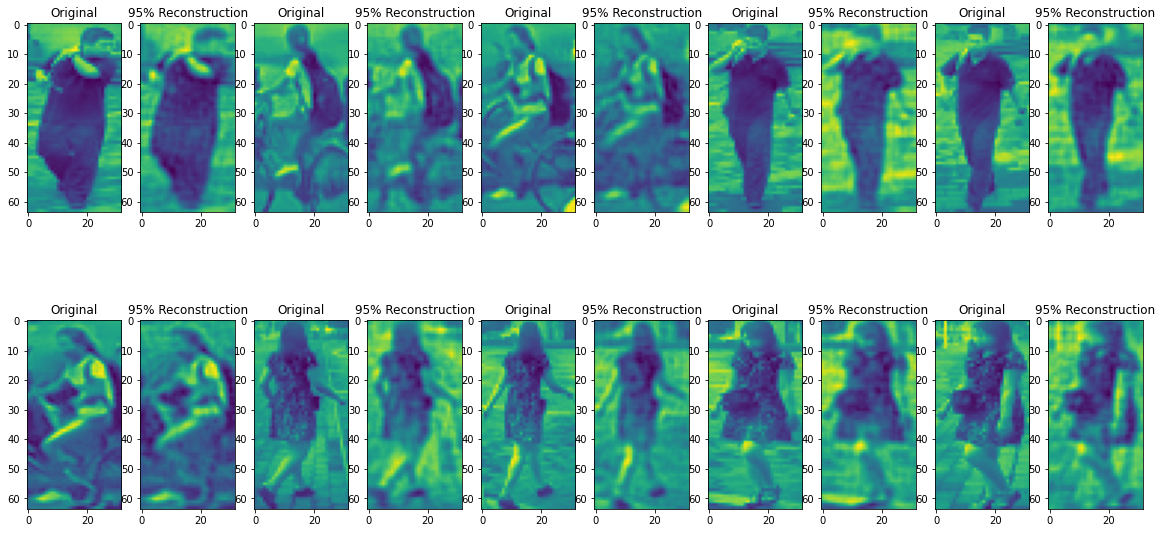

In [13]:
transformed_train_95 = transformed[:, 0:top95]
gallery_feat_95 = gallery_feat[:, 0:top95]
probe_feat_95 = probe_feat[:, 0:top95]

transformed_train_95 = transformed[:, 0:top95]

fig = plt.figure(figsize=[20, 10])
count = 0
for i in range(5):
    for j in range(2):
        ax = fig.add_subplot(2, 10, count*2 + 1)
        ax.imshow(numpy.reshape(vectorise(train_X_small)[count,:] - pca.mean_, img_size))
        ax.set_title('Original');

        ax = fig.add_subplot(2, 10, count*2 + 2)
        ax.imshow(numpy.reshape(pca.components_[0:top95,:].transpose().dot(numpy.reshape(transformed[count,0:top95], (-1, 1))), img_size))
        ax.set_title('95% Reconstruction');
        count += 1

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

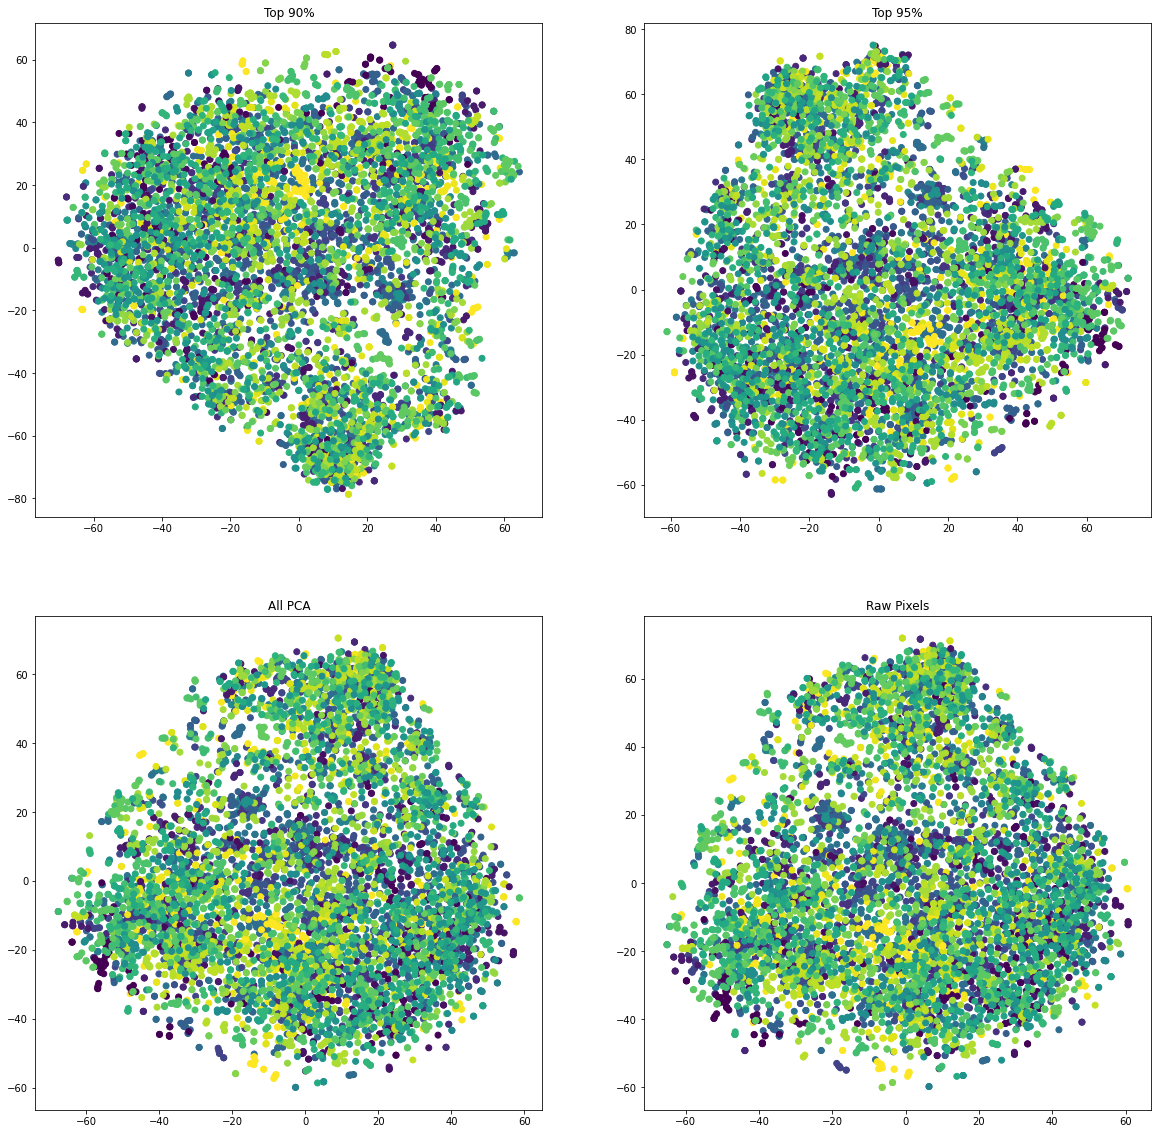

In [14]:
embeddings_90 = TSNE(random_state=4).fit_transform(transformed[:, 0:top90])
embeddings_95 = TSNE(random_state=4).fit_transform(transformed[:, 0:top95])
embeddings_all = TSNE(random_state=4).fit_transform(transformed)
embeddings_pix = TSNE(random_state=4).fit_transform(train_fea)

fig = plt.figure(figsize=[20, 20])
ax = fig.add_subplot(2, 2, 1)
ax.scatter(embeddings_90[:,0], embeddings_90[:,1], c=train_Y)
ax.set_title('Top 90%')

ax = fig.add_subplot(2, 2, 2)
ax.scatter(embeddings_95[:,0], embeddings_95[:,1], c=train_Y)
ax.set_title('Top 95%')

ax = fig.add_subplot(2, 2, 3)
ax.scatter(embeddings_all[:,0], embeddings_all[:,1], c=train_Y)
ax.set_title('All PCA')

ax = fig.add_subplot(2, 2, 4)
ax.scatter(embeddings_pix[:,0], embeddings_pix[:,1], c=train_Y)
ax.set_title('Raw Pixels');

## Task 2
Develop and evaluate a deep learning based method for person re-identification,
using one of the methods covered in Week 7. The method should be evaluated on the
test set by considering Top-1, Top-5 and Top-10 performance. A CMC (cumulative
match characteristic) curve should also be provided.
4


Base Network setup

In [15]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [16]:
embedding_size = 64
# input_img_size = (img_size[0], img_size[1], 3)
input_img_size = train_X.shape[1:]
dummy_input = keras.Input(input_img_size)
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = K.l2_normalize(anchor, axis=1)
        positive = K.l2_normalize(positive, axis=1)
        negative = K.l2_normalize(negative, axis=1)

        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
input_anchor = keras.Input(input_img_size, name='Anchor')
input_positive = keras.Input(input_img_size, name='Positive')
input_negative = keras.Input(input_img_size, name='Negative')

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([embedding_anchor, embedding_positive, embedding_negative])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor (InputLayer)            [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Positive (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Negative (InputLayer)          [(None, 128, 64, 3)  0           []                               
                                ]                                                             

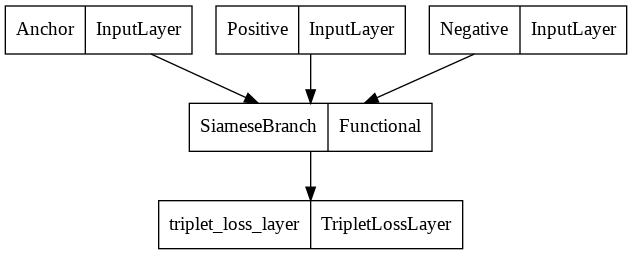

In [17]:
triplet_network = keras.Model(inputs=[input_anchor, input_positive, input_negative], outputs=loss_layer)
triplet_network.summary()
keras.utils.plot_model(triplet_network)

In [18]:
triplet_network.compile(optimizer=keras.optimizers.RMSprop())

batch_size = 128
training_gen = triplet_generator(train_X, train_Y, batch_size)
triplet_test_x = get_triplet_data(gallery_X, gallery_Y, len(gallery_Y))

# get a start time
time_1 = process_time()
triplet_network.fit(training_gen, steps_per_epoch = 60000 // batch_size, epochs=10, validation_data=(triplet_test_x, None))
time_2 = process_time()
embeddings = base_network.predict(train_X)
time_3 = process_time()

# record runtime
train_time_results["Deep Learning"] = time_2 - time_1
inference_time_results["Deep Learning"] = time_3 - time_2


Epoch 1/10
468/468 [==============================] - 89s 158ms/step - loss: 30.5794 - val_loss: 1.0465
Epoch 2/10
468/468 [==============================] - 73s 155ms/step - loss: 15.5243 - val_loss: 1.1061
Epoch 3/10
468/468 [==============================] - 73s 155ms/step - loss: 11.3046 - val_loss: 0.9071
Epoch 4/10
468/468 [==============================] - 73s 156ms/step - loss: 8.8965 - val_loss: 0.7559
Epoch 5/10
468/468 [==============================] - 72s 155ms/step - loss: 7.3237 - val_loss: 0.7234
Epoch 6/10
468/468 [==============================] - 73s 156ms/step - loss: 6.2143 - val_loss: 0.5468
Epoch 7/10
468/468 [==============================] - 73s 155ms/step - loss: 5.3430 - val_loss: 0.5978
Epoch 8/10
468/468 [==============================] - 72s 155ms/step - loss: 4.6838 - val_loss: 0.4551
Epoch 9/10
468/468 [==============================] - 72s 154ms/step - loss: 4.2810 - val_loss: 0.5482
Epoch 10/10
468/468 [==============================] - 72s 155ms/step 

In [30]:
triplet_test_x = get_triplet_data(probe_X, probe_Y, len(probe_Y))

triplet_test_x[0].shape

(301, 128, 64, 3)

Examine embeddings

In [31]:
embeddings = base_network.predict(train_X)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_Y.flatten());

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

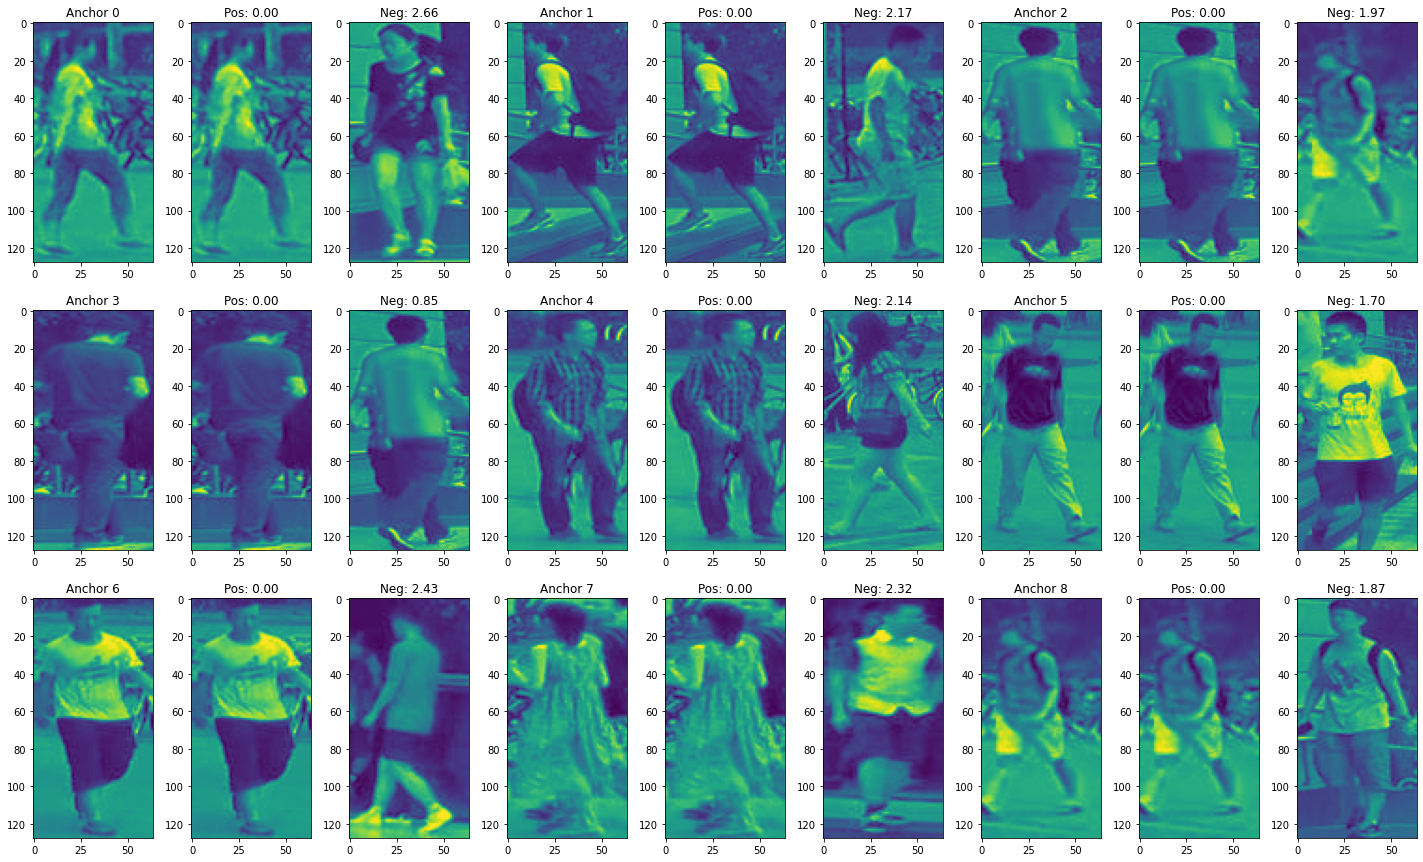

In [28]:
def ComputeDistance(x, y):
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    dist = K.sum(K.square(x - y), axis=-1)
    return dist

x = get_triplet_data(probe_X, probe_Y, 9)
anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 15])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Anchor ' + str(i))
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pos: ' + '%1.2f' % float(pos_dists[i]))
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Neg: ' + '%1.2f' % float(neg_dists[i]))

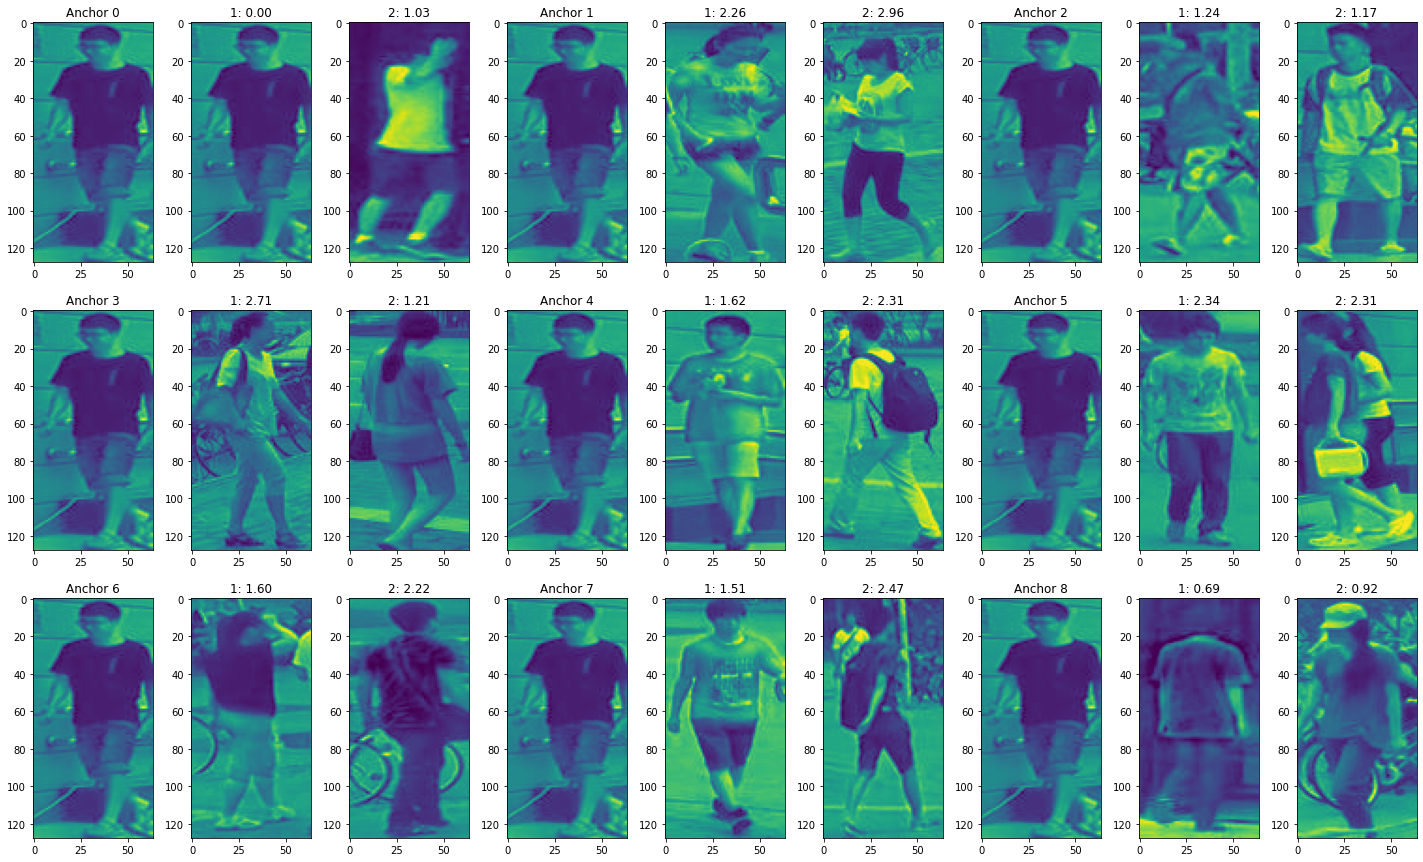

In [27]:
for i in range(9):
    x[0][i,:] = x[0][0,:]

anchor_embedding = base_network.predict(x[0])
positive_embedding = base_network.predict(x[1])
negative_embedding = base_network.predict(x[2])
pos_dists = ComputeDistance(anchor_embedding, positive_embedding)
neg_dists = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[25, 15])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Anchor ' + str(i))
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('1: ' + '%1.2f' % float(pos_dists[i]))
    
    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('2: ' + '%1.2f' % float(neg_dists[i]))

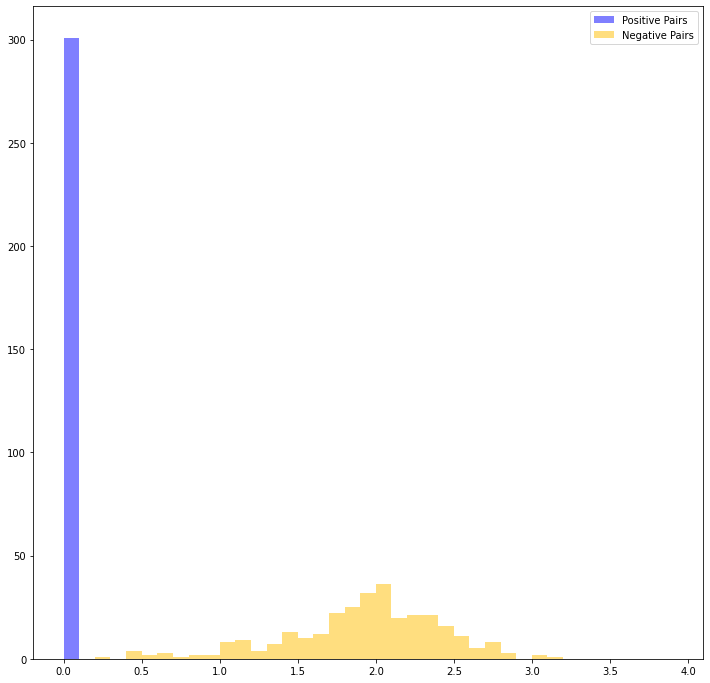

In [32]:
anchor_embedding = base_network.predict(triplet_test_x[0])
positive_embedding = base_network.predict(triplet_test_x[1])
negative_embedding = base_network.predict(triplet_test_x[2])

positive_distances = ComputeDistance(anchor_embedding, positive_embedding)
negative_distances = ComputeDistance(anchor_embedding, negative_embedding)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.hist(positive_distances, numpy.arange(0, 4.0, 0.1), label='Positive Pairs', fc=(0, 0, 1.0, 0.5))
ax.hist(negative_distances, numpy.arange(0, 4.0, 0.1), label='Negative Pairs', fc=(1.0, 0.75, 0, 0.5))
ax.legend();

Compute CMC and get top-N accuracy

(301,)
0.20930232558139536
0.46179401993355484
0.5714285714285714


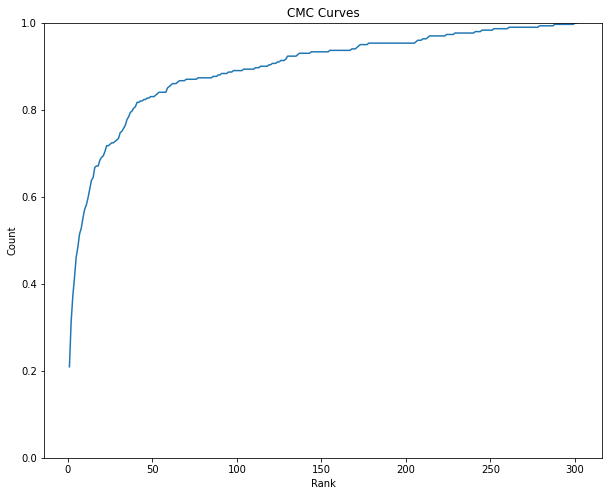

In [23]:
gallery_embedding = base_network.predict(gallery_X)
probe_embedding = base_network.predict(probe_X)

ranked_hist = get_ranked_histogram_l1_distance(gallery_embedding, gallery_Y, probe_embedding, probe_Y, False)
dl_cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(dl_cmc)

print(dl_cmc.shape)
dl_top_1 = dl_cmc[0]
dl_top_5 = dl_cmc[4]
dl_top_10 = dl_cmc[9]

print(dl_top_1)
print(dl_top_5)
print(dl_top_10)

## Comparison 

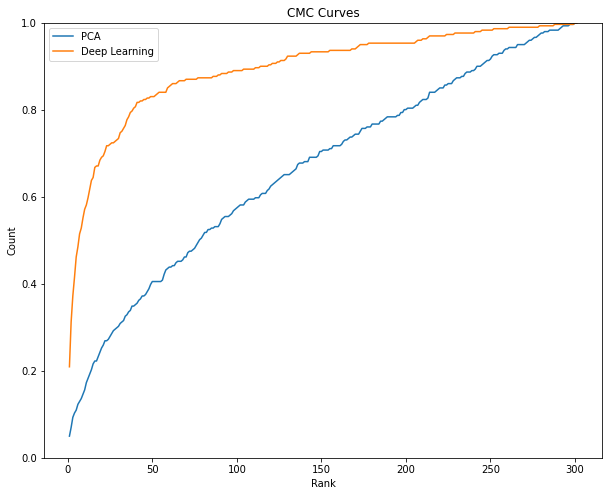

In [24]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, len(pca_cmc)+1), pca_cmc, label="PCA")
ax.plot(range(1, len(dl_cmc)+1), dl_cmc, label="Deep Learning")


ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_ylim([0, 1.0])
ax.set_title('CMC Curves') 
ax.legend()

[0.20930232558139536, 0.46179401993355484, 0.5714285714285714]
[0.04983388704318937, 0.10963455149501661, 0.15614617940199335]


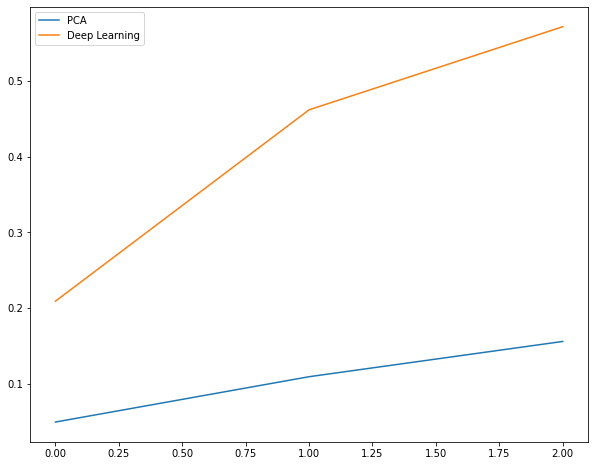

In [25]:
pca_accuracy = [pca_top_1, pca_top_5, pca_top_10]
dl_accuracy = [dl_top_1, dl_top_5, dl_top_10]
print(dl_accuracy)
print(pca_accuracy)

fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(pca_accuracy, label="PCA")
ax.plot(dl_accuracy, label="Deep Learning")
ax.legend()


{'PCA': 11.850539591, 'Deep Learning': 1243.4614676770002}
{'PCA': 1.2563508660000018, 'Deep Learning': 1.6235259739999037}


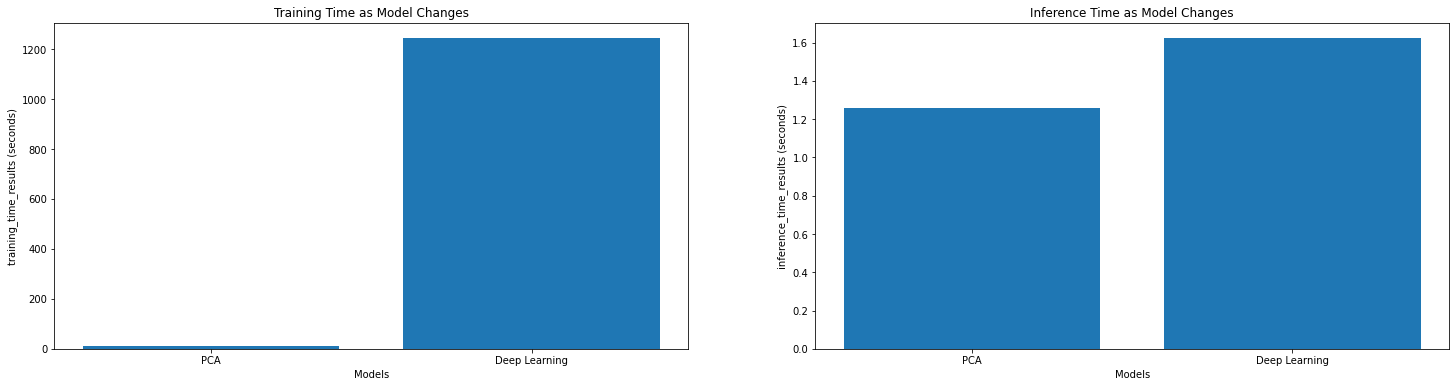

In [26]:
# plot runtime
fig = plt.figure(figsize =(25, 6))


ax = fig.add_subplot(1,2,1)
ax.bar(list(train_time_results.keys()), list(train_time_results.values()))
ax.set_xlabel("Models")
ax.set_ylabel("training_time_results (seconds)")
ax.set_title("Training Time as Model Changes")


ax = fig.add_subplot(1,2,2)
ax.bar(list(inference_time_results.keys()), list(inference_time_results.values()))
ax.set_xlabel("Models")
ax.set_ylabel("inference_time_results (seconds)")
ax.set_title("Inference Time as Model Changes")

print(train_time_results)
print(inference_time_results)